# 🤖 LLM: Многомерное прогнозирование с большими языковыми моделями

Этот блокнот реализует многомерное прогнозирование финансовых временных рядов с использованием **больших языковых моделей (LLM)** - инновационный подход к анализу временных рядов через естественный язык.

## 🎯 Основные особенности

- **Многомерные данные**: используем данные из папки `/data/multivariate_series/`
- **Поэтапные признаки**: различные этапы добавления фичей согласно progressive feature analysis
- **Walk-forward прогнозирование**: честное тестирование с расширяющимся окном
- **Горизонт прогноза**: 10 точек
- **Размер теста**: 11 точек
- **Множественные LLM**: GPT-4o-mini, DeepSeek, Claude, LLaMA, Gemini и другие
- **Метрики**: RMSE, MAPE, DA (Directional Accuracy)

## 📊 Структура этапов признаков

1. **Этап 1**: Только цены закрытия (close)
2. **Этап 2**: + Аномалии (anomaly)
3. **Этап 3**: + Новостные настроения (weighted_score_with_decay)
4. **Этап 4**: + Базовые OHLCV признаки
5. **Этап 5**: + Технические индикаторы
6. **Этап 6**: + Статистические признаки (TSFresh)

## 🤖 LLM модели для тестирования

### 🌐 Через OpenRouter API:
- **GPT-4o-mini**: компактная версия GPT-4o от OpenAI
- **LLaMA-4**: модель от Meta
- **Claude-Haiku**: быстрая модель от Anthropic
- **DeepSeek-R1**: рассуждающая модель от DeepSeek
- **Gemini-2.5-Pro**: новейшая модель от Google
- **Qwen-QwQ**: модель от Alibaba с рассуждением

### 🔗 Прямые API:
- **DeepSeek-Chat**: специализированная модель от DeepSeek
- **GigaChat**: российская LLM от Сбербанка

## 🔬 Методология
- **Zero-shot прогнозирование**: без дообучения, использование естественного языка
- **Patch-based подход**: разбиение временного ряда на патчи с статистическими подсказками
- **Walk-forward валидация**: строгая проверка на будущих данных с расширяющимся окном
- **Robust parsing**: извлечение числовых значений из ответов LLM
- **Anomaly handling**: обработка галлюцинаций и повторные попытки
- **Прогноз**: 10 точек вперед на каждом шаге


In [1]:
# Установка и импорты
import warnings
warnings.filterwarnings('ignore')

import os
import time
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import statistics
import re
from typing import List, Dict, Tuple, Optional
from datetime import datetime
import logging

# Проверка и установка необходимых библиотек
try:
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    from langchain.schema import HumanMessage, SystemMessage
    from langchain_gigachat import GigaChat
    print("✅ Основные библиотеки доступны")
except ImportError:
    print("📦 Устанавливаем недостающие библиотеки...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", 
                          "requests", "langchain", "langchain-gigachat", 
                          "gigachat", "openai", "--quiet"])
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    from langchain.schema import HumanMessage, SystemMessage
    from langchain_gigachat import GigaChat
    print("✅ Библиотеки установлены и импортированы")

# Настройка визуализации
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Установим читаемый формат для вывода чисел
pd.options.display.float_format = '{:.4f}'.format

print("📚 Библиотеки загружены успешно!")
print("🤖 Готов к работе с LLM моделями!")

✅ Основные библиотеки доступны
📚 Библиотеки загружены успешно!
🤖 Готов к работе с LLM моделями!


In [2]:
# Конфигурация (точно как в других multivariate блокнотах)
DATA_PATH = "../../data/multivariate_series/"
OUTPUT_PATH = "results/multivariate_llm/"
FORECAST_HORIZON = 10  # Прогнозируем на 10 точек
TEST_SIZE = 11  # Размер тестового набора
PATCH_SIZE = 30  # Размер патча для LLM анализа

# Создаем папку для результатов
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

# Список тикеров (точно как в других multivariate блокнотах)
TICKERS = ['AFLT', 'LKOH', 'MOEX', 'NVTK', 'PIKK', 'SBER', 'VKCO', 'VTBR', 'X5', 'YDEX']

# Названия этапов для отображения (как в LLM_Progressive_Clean - 8 этапов)
STAGE_NAMES = {
    1: "Базовая цена (close)",
    2: "Цена + аномалии", 
    3: "Цена + аномалии + новости",
    4: "Всё выше + заголовки новостей",
    5: "Всё выше + OHLCV",
    6: "Всё выше + технические индикаторы",
    7: "Всё выше + статистические признаки TSFresh",
    8: "Всё из этапа 7 + визуализация графиков"
}

# API ключи (замените на свои!)
API_KEYS = {
    'openrouter': "",
    'deepseek': "",
    'gigachat': ""
}

print(f"Настройки:")
print(f"- Путь к данным: {DATA_PATH}")
print(f"- Горизонт прогноза: {FORECAST_HORIZON}")
print(f"- Размер тест. данных: {TEST_SIZE}")
print(f"- Размер патча: {PATCH_SIZE}")
print(f"- Количество тикеров: {len(TICKERS)}")
print(f"- Папка результатов: {OUTPUT_PATH}")

Настройки:
- Путь к данным: ../../data/multivariate_series/
- Горизонт прогноза: 10
- Размер тест. данных: 11
- Размер патча: 30
- Количество тикеров: 10
- Папка результатов: results/multivariate_llm/


In [55]:
# Функции для подготовки признаков по этапам (как в LLM_Progressive_Clean)
import base64
import io

# Predefined feature groups (как в LLM_Progressive_Clean)
_BASE = ['close', 'anomaly', 'weighted_score_with_decay']
_OHLV = ['open', 'high', 'low', 'volume']
_TECH = [
    'return', 'SMA_14', 'SMA_50', 'EMA_14', 'EMA_50', 'RSI_14',
    'MACD', 'MACD_signal', 'BB_hband', 'BB_lband', 'ATR_14', 'OBV', 'VWAP'
]

_FEATURE_MAP = {
    1: ['close'],
    2: ['close', 'anomaly'],
    3: ['close', 'anomaly', 'weighted_score_with_decay'],
    4: ['close', 'anomaly', 'weighted_score_with_decay', 'daily_headlines'],
    5: _BASE + _OHLV,
    6: _BASE + _OHLV + _TECH,
    7: _BASE + _OHLV + _TECH + ['value__'],  # TSFresh признаки
    8: _BASE + _OHLV + _TECH + ['value__'],  # То же что 7 + визуализация
}

def prepare_features_for_stage(df, stage):
    """
    Возвращает список колонок для определенного этапа (как в LLM_Progressive_Clean)
    """
    if stage not in _FEATURE_MAP:
        raise ValueError(f"Unsupported stage: {stage}")
    feats = _FEATURE_MAP[7] if stage == 8 else _FEATURE_MAP[stage]
    # Расширяем wildcard 'value__' для tsfresh
    return [col for col in df.columns
            if col in feats or any(feat == 'value__' and 'value__' in col for feat in feats)]

def create_chart_image(window_data, ticker, width: float = 16, height: float = 12, dpi: int = 200) -> str | None:
    """
    Создает график цены + SMA(14/50) + RSI(14) и возвращает base64-encoded PNG,
    но уже уменьшенного размера (width x height дюймов, dpi точек на дюйм).
    """
    try:
        fig, (ax_price, ax_rsi) = plt.subplots(2, 1, figsize=(width, height), dpi=dpi)

        # График цены + SMA
        ax_price.plot(window_data.index, window_data['close'], linewidth=2, marker='o', label='Close')
        for sma, color in (('SMA_14', 'red'), ('SMA_50', 'green')):
            if sma in window_data.columns:
                ax_price.plot(window_data.index, window_data[sma],
                              linestyle='--', linewidth=1.5, alpha=0.7, color=color, label=sma)
        ax_price.set_title(f"{ticker} – Window Price", fontsize=10)
        ax_price.legend(fontsize=8)
        ax_price.grid(alpha=0.3)

        # График RSI
        if 'RSI_14' in window_data.columns:
            ax_rsi.plot(window_data.index, window_data['RSI_14'], linewidth=2, label='RSI (14)')
            ax_rsi.axhline(70, linestyle='--', alpha=0.7, label='Overbought')
            ax_rsi.axhline(30, linestyle='--', alpha=0.7, label='Oversold')
            ax_rsi.set_ylim(0, 100)
            ax_rsi.legend(fontsize=8)
            ax_rsi.grid(alpha=0.3)
        else:
            fig.delaxes(ax_rsi)

        plt.tight_layout()

        # Кодируем в Base64
        buf = io.BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)
        img_b64 = base64.b64encode(buf.read()).decode('utf-8')
        plt.close(fig)
        return img_b64

    except Exception as e:
        logger.error(f"Ошибка создания графика для {ticker}: {e}")
        return None
print("✅ Функции подготовки признаков и визуализации созданы")

✅ Функции подготовки признаков и визуализации созданы


In [56]:
# Вспомогательные функции для LLM работы
def calculate_directional_accuracy(actual: np.ndarray, predicted: np.ndarray) -> float:
    """Вычисляет точность направления (DA)"""
    if len(actual) < 2 or len(predicted) < 2:
        return 0.0
    
    actual_direction = np.diff(actual) > 0
    predicted_direction = np.diff(predicted) > 0
    
    return np.mean(actual_direction == predicted_direction) * 100

def parse_llm_response(response_text: str) -> float:
    """Извлекает числовое значение из ответа LLM"""
    try:
        # Ищем первое число в ответе
        match = re.search(r"[-+]?\d*\.?\d+", str(response_text).strip())
        return float(match.group(0)) if match else np.nan
    except (ValueError, AttributeError):
        return np.nan

def load_ticker_data(ticker: str) -> Optional[pd.DataFrame]:
    """Загружает данные для тикера"""
    file_path = f"{DATA_PATH}{ticker}_multivariate.csv"
    
    if not os.path.exists(file_path):
        print(f"⚠️ Файл не найден: {file_path}")
        return None
    
    try:
        df = pd.read_csv(file_path)
        
        # Проверяем наличие timestamp колонки
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.set_index('timestamp')
        
        # Сортируем по времени
        df = df.sort_index()
        
        # Проверяем наличие основных колонок
        required_cols = ['close']
        if not all(col in df.columns for col in required_cols):
            print(f"⚠️ Отсутствуют необходимые колонки в {ticker}")
            return None
        
        print(f"✅ Загружен {ticker}: {len(df)} точек, {len(df.columns)} признаков")
        return df
        
    except Exception as e:
        print(f"❌ Ошибка загрузки {ticker}: {e}")
        return None

# Функция создания патчей как в LLM_Progressive_Clean
def make_patch_messages(window_data, stage, ticker="", patch_size=5, model="DEFAULT"):
    """Создает детальные патчи для LLM промптов (как в LLM_Progressive_Clean)"""
    msgs = []
    features = prepare_features_for_stage(window_data, stage)
    available_features = [f for f in features if f in window_data.columns]
    
    n_patches = max(1, len(window_data) // patch_size)
    actual_patch_size = len(window_data) // n_patches
    
    for i in range(n_patches):
        start_idx = i * actual_patch_size
        end_idx = min((i + 1) * actual_patch_size, len(window_data))
        patch_data = window_data.iloc[start_idx:end_idx]
        
        characteristics = []
        
        # Всегда добавляем цены
        if 'close' in available_features:
            prices = [f"{val:.2f}" for val in patch_data['close'].values]
            characteristics.append(f"Prices: {', '.join(prices)}")
        
        if stage >= 2 and 'anomaly' in available_features:
            anomalies = [str(int(val)) if not pd.isna(val) else "0" for val in patch_data['anomaly'].values]
            characteristics.append(f"Anomaly (0-no, 1-yes): {', '.join(anomalies)}")
        
        if stage >= 3 and 'weighted_score_with_decay' in available_features:
            scores = [f"{val*100:.0f}" if not pd.isna(val) else "0" for val in patch_data['weighted_score_with_decay'].values]
            characteristics.append(f"News sentiment (-100 to +100): {', '.join(scores)}")
        
        if stage >= 4 and 'daily_headlines' in available_features:
            headlines = patch_data['daily_headlines'].dropna()
            if len(headlines) > 0:
                last_headline = str(headlines.iloc[-1])[:100]
                characteristics.append(f"Latest news: {last_headline}")
        
        if stage >= 5:
            if 'open' in available_features:
                opens = [f"{val:.2f}" for val in patch_data['open'].values]
                characteristics.append(f"Open prices: {', '.join(opens)}")
            
            if 'high' in available_features:
                highs = [f"{val:.2f}" for val in patch_data['high'].values]
                characteristics.append(f"High prices: {', '.join(highs)}")
            
            if 'low' in available_features:
                lows = [f"{val:.2f}" for val in patch_data['low'].values]
                characteristics.append(f"Low prices: {', '.join(lows)}")
            
            if 'volume' in available_features:
                volumes = [f"{val:.0f}" if not pd.isna(val) else "0" for val in patch_data['volume'].values]
                characteristics.append(f"Volumes: {', '.join(volumes)}")
        
        if stage >= 6:
            if 'EMA_14' in available_features:
                ema_vals = [f"{val:.2f}" if not pd.isna(val) else "0" for val in patch_data['EMA_14']]
                characteristics.append(f"EMA(14): {', '.join(ema_vals)}")
        
            if 'RSI_14' in available_features:
                rsi_vals = [f"{val:.1f}" if not pd.isna(val) else "50" for val in patch_data['RSI_14'].values]
                characteristics.append(f"RSI: {', '.join(rsi_vals)}")
            
            if 'MACD' in available_features:
                macd_vals = [f"{val:.3f}" if not pd.isna(val) else "0" for val in patch_data['MACD'].values]
                characteristics.append(f"MACD: {', '.join(macd_vals)}")
            
            if 'return' in available_features:
                returns = [f"{val*100:.1f}%" if not pd.isna(val) else "0%" for val in patch_data['return'].values]
                characteristics.append(f"Returns: {', '.join(returns)}")

            if 'ATR_14' in available_features:
                atr_vals = [f"{val:.2f}" if not pd.isna(val) else "0" for val in patch_data['ATR_14']]
                characteristics.append(f"ATR(14): {', '.join(atr_vals)}")
    
            if 'VWAP' in available_features:
                vwap_vals = [f"{val:.2f}" if not pd.isna(val) else "0" for val in patch_data['VWAP']]
                characteristics.append(f"VWAP: {', '.join(vwap_vals)}")

        if stage >= 7:
            # Этап 7+: добавляем статистические признаки (выборочно)
            tsfresh_stats = [
                'value__mean',
                'value__maximum',
                'value__minimum',
                'value__standard_deviation',
                'value__partial_autocorrelation__lag_3',
                'value__autocorrelation__lag_5',
                'value__longest_strike_above_mean'
            ]
            for feat in tsfresh_stats:
                if feat in available_features:
                    vals = [f"{v:.2f}" if not pd.isna(v) else "0" for v in patch_data[feat]]
                    characteristics.append(f"{feat}: {', '.join(vals)}")
        
        content = f"Патч {i+1}: " + " | ".join(characteristics)
        msgs.append({"role": "system", "content": content})
    
    # Добавляем график для 8 этапа (если поддерживается vision)
    if stage == 8:
        print("Working dir:", os.getcwd())
        image_base64 = create_chart_image(window_data, ticker)
        if image_base64:
            filename = f"{ticker}_chart.png"
            with open(filename, "wb") as f:
                f.write(base64.b64decode(image_base64))
            
            if model == "DEFAULT":
                msgs.append({
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": (
                                "You are a seasoned financial analyst. "
                                "Study the attached price chart for the ticker, which shows closing prices, SMA(14/50), and RSI(14). "
                                "Determine the current trend, momentum levels, and any support or resistance. "
                                "Then predict the next closing price. "
                                "Return only the numeric value — no explanation or extra text."
                            )
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/png;base64,{image_base64}"
                            }
                        }
                    ]
                })
            elif model == "DEEPSEEK":
                prompt_text = (
                    "You are a seasoned financial analyst. "
                    "Study the attached price chart for the ticker, which shows closing prices, SMA(14/50), and RSI(14). "
                    "Determine the current trend, momentum levels, and any support or resistance. "
                    "Then predict the next closing price. "
                    "Return only the numeric value — no explanation or extra text.\n\n"
                    f"![plot](data:image/png;base64,{image_base64})"
                )
                msgs.append({
                    "role": "user",
                    "content": prompt_text
                })

            elif model is GigaChat:
                # 2) Декодируем и сохраняем в файл
                filename = f"{ticker}_chart.png"
                with open(filename, "wb") as f:
                    f.write(base64.b64decode(image_base64))
                
                # 3) Загружаем файл в GigaChat
                with open(filename, "rb") as f:
                    file_obj = giga.upload_file(f)
                file_id = getattr(file_obj, "id", None) or getattr(file_obj, "id_", None)
                if not file_id:
                    raise RuntimeError("Не удалось получить ID загруженного файла")
        
                # Опционально: удалить локальный файл, если он больше не нужен
                #os.remove(filename)
        
                # 4) Формируем сообщение с вложением
                msgs.append({
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": (
                                "You are a seasoned financial analyst. "
                                "Study the attached price chart for the ticker, which shows closing prices, SMA(14/50), and RSI(14). "
                                "Determine the current trend, momentum levels, and any support or resistance. "
                                "Then predict the next closing price. "
                                "Return only the numeric value — no explanation or extra text."
                            )
                        },
                        {
                            "type": "text",
                            "text": "Use attached image",
                            "attachments": [file_id]
                        }
                    ]
                })

    return msgs


def convert_to_langchain_messages(raw_msgs):
    """
    Преобразует список словарей вида {'role': 'system'|'user', 'content': ...}
    в список LangChain-сообщений.
    """
    lc_msgs = []
    for m in raw_msgs:
        role = m.get("role")
        content = m.get("content")
        
        # Если контент — это список блоков (stage 8 с картинкой)
        if isinstance(content, list):
            parts = []
            for block in content:
                if block.get("type") == "text":
                    parts.append(block["text"])
                elif block.get("type") == "image_url":
                    # Вставляем просто URL — GigaChat подхватит вложение
                    parts.append(block["image_url"]["url"])
            text = "\n\n".join(parts)
        
        # Если контент — простая строка
        else:
            text = content
        
        # Конвертация по роли
        if role == "system":
            lc_msgs.append(SystemMessage(content=text))
        elif role == "user":
            lc_msgs.append(HumanMessage(content=text))
        else:
            # при необходимости можно добавить другие роли
            lc_msgs.append(HumanMessage(content=text))
    
    return lc_msgs


print("✅ Вспомогательные функции для LLM созданы")

✅ Вспомогательные функции для LLM созданы


In [57]:
# Классы LLM предикторов для разных API (адаптированы из LLM_Progressive_Clean)
class OpenRouterStreamPredictor:
    """LLM-предиктор через OpenRouter API с поддержкой стрима SSE."""
    
    def __init__(self, api_key, model_name, max_retries=2, drop_threshold=0.15):
        self.api_url = "https://openrouter.ai/api/v1/chat/completions"
        self.headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
            "HTTP-Referer": "https://github.com/",
            "X-Title": "Financial Time Series Forecasting"
        }
        self.model_name = model_name
        self.max_retries = max_retries
        self.drop_threshold = drop_threshold

    def predict(self, window_data, stage, ticker="", patch_size=5):
        """
        Стрим-прогноз следующего значения на основе временного окна:
        1) формирует патчи через make_patch_messages,
        2) отправляет запрос с stream=True,
        3) собирает SSE-чанки в текст,
        4) парсит итоговый текст в число,
        5) проверяет на NaN и аномалию, с повтором до max_retries.
        """
        prev_price = window_data['close'].iloc[-1]
        
        for attempt in range(1, self.max_retries + 1):
            # 1) Формируем сообщения
            msgs = make_patch_messages(window_data, stage, ticker, patch_size)
            msgs.insert(0, {
                "role": "system",
                "content": (
                    "You are an expert financial forecaster. "
                    "Given the input time series data, predict the next closing price "
                    "and return only the numeric value—no explanations or additional text."
                )
            })
            if attempt > 1:
                msgs.insert(1, {
                    "role": "system",
                    "content": (
                        "Previous attempt failed or gave implausible value. "
                        "Please retry and return only the numeric value."
                    )
                })
            msgs.append({
                "role": "user",
                "content": (
                    "Based on the provided financial metrics, "
                    "predict the next closing price as a single numeric value."
                )
            })
            
            # 2) Отправляем стрим-запрос
            payload = {
                "model": self.model_name,
                "messages": msgs,
                "stream": True,
                "max_tokens": 20,
                "temperature": 0.1
            }
            try:
                response = requests.post(
                    self.api_url,
                    headers=self.headers,
                    json=payload,
                    stream=True,
                    timeout=240
                )
                response.raise_for_status()
            except Exception as e:
                print(f"    Ошибка подключения (попытка {attempt}): {e}")
                if attempt >= self.max_retries:
                    return prev_price
                time.sleep(1)
                continue
            
            # 3) Сбор SSE-чанков
            collected = ""
            for line in response.iter_lines(decode_unicode=True):
                if not line or line.strip() == "[DONE]":
                    continue
                if line.startswith("data: "):
                    try:
                        data = json.loads(line[len("data: "):])
                        delta = data["choices"][0].get("delta", {})
                        token = delta.get("content", "")
                        collected += token
                    except json.JSONDecodeError:
                        # игнорируем некорректные чанки
                        continue
            
            text = collected.strip()
            
            # 4) Парсим ответ в число
            try:
                pred = parse_llm_response(text)
            except Exception:
                try:
                    pred = float(text)
                except Exception:
                    pred = np.nan
            
            # 5) Проверка на NaN и аномалии
            if np.isnan(pred):
                print(f"    Попытка {attempt}: не удалось получить число из '{text}'")
                if attempt >= self.max_retries:
                    return prev_price
                time.sleep(1)
                continue
            
            # Аномальные скачки
            low = prev_price * (1 - self.drop_threshold)
            high = prev_price * (1 + self.drop_threshold)
            if pred < low or pred > high:
                print(f"    Попытка {attempt}: аномальный прогноз {pred:.2f} (prev={prev_price:.2f})")
                if attempt < self.max_retries:
                    time.sleep(1)
                    continue
                # на последней попытке ограничиваем
                return np.clip(pred, low, high)
            
            # Успешный результат
            return pred
        
        # все попытки исчерпаны
        return prev_price

In [58]:
from openai import OpenAI

class OpenRouterOpenAIStreamPredictor:
    """LLM-предиктор через OpenRouter API, но с официальной библиотекой openai."""
    
    def __init__(
        self,
        api_key: str,
        model_name: str,
        max_retries: int = 2,
        drop_threshold: float = 0.15,
        base_url: str = "https://openrouter.ai/api/v1"
    ):
        """
        Args:
            api_key: ваш ключ для OpenRouter
            model_name: имя модели (напр. "gpt-4o-mini" или "deepseek-chat")
            max_retries: число попыток при сбоях или галлюцинациях
            drop_threshold: порог для отброса слишком низких/высоких прогнозов
            base_url: endpoint OpenRouter (по умолчанию "https://openrouter.ai/api/v1")
        """
        self.client = OpenAI(
            api_key=api_key,
            base_url=base_url,
        )
        self.model_name = model_name
        self.max_retries = max_retries
        self.drop_threshold = drop_threshold

    def predict(self, window_data, stage, ticker: str = "", patch_size: int = 5) -> float:
        """
        Стрим-прогноз следующего значения:
        1) Формируем патчи через make_patch_messages
        2) Отправляем stream=True
        3) Собираем по‐токенно ответ
        4) Парсим в число и проверяем пороги
        """
        prev_price = window_data['close'].iloc[-1]

        system_prompt = {
            "role": "system",
            "content": (
                "You are an expert financial forecaster. "
                "Given the input time series data, predict the next closing price "
                "and return only the numeric value—no explanations or additional text."
            )
        }
        user_prompt = {
            "role": "user",
            "content": (
                "Based on the provided financial metrics, predict the next closing price "
                "as a single numeric value."
            )
        }

        for attempt in range(1, self.max_retries + 1):
            # 1) сборка сообщений
            msgs = make_patch_messages(window_data, stage, ticker, patch_size)
            msgs.insert(0, system_prompt)
            if attempt > 1:
                msgs.insert(1, {
                    "role": "system",
                    "content": (
                        "Previous attempt failed or gave implausible value. "
                        "Please retry and return only the numeric value."
                    )
                })
            msgs.append(user_prompt)

            # 2) вызов chat.completions с stream=True
            try:
                stream = self.client.chat.completions.create(
                    model=self.model_name,
                    messages=msgs,
                    stream=True,
                    temperature=0.1,
                    max_tokens=20000
                )

                # 3) сбор ответных токенов
                collected = ""
                for chunk in stream: 
                    delta = chunk.choices[0].delta  
                    # Пропускаем дельты без поля content  
                    token = getattr(delta, "content", "") or ""  
                    if token:  
                        collected += token
            except Exception as e:
                print(f"    Ошибка подключения (попытка {attempt}): {e}")
                if attempt >= self.max_retries:
                    return prev_price
                time.sleep(1)
                continue



            text = collected.strip()

            # 4) попытка спарсить число
            try:
                pred = parse_llm_response(text)
            except Exception:
                try:
                    pred = float(text)
                except:
                    pred = np.nan

            # 5) проверки
            if np.isnan(pred):
                print(f"    Попытка {attempt}: не удалось получить число из '{text}'")
                if attempt >= self.max_retries:
                    return prev_price
                time.sleep(1)
                continue

            low = prev_price * (1 - self.drop_threshold)
            high = prev_price * (1 + self.drop_threshold)
            if pred < low or pred > high:
                print(f"    Попытка {attempt}: аномальный прогноз {pred:.2f} (prev={prev_price:.2f})")
                if attempt < self.max_retries:
                    time.sleep(1)
                    continue
                return np.clip(pred, low, high)

            return pred

        # если все попытки исчерпаны
        return prev_price

In [59]:
class BaseLinePredictor:
    """BaseLine."""
    
    def __init__(self, api_key, model_name, max_retries=2, drop_threshold=0.15):
        self.model_name = model_name
        self.max_retries = max_retries
        self.drop_threshold = drop_threshold

    def predict(self, window_data, stage, ticker="", patch_size=5):
        """
        NativeReapeat :)
        """
        prev_price = window_data['close'].iloc[-1]
        
        # все попытки исчерпаны
        return prev_price

In [60]:
from openai import OpenAI
import numpy as np
import time
import logging

logger = logging.getLogger(__name__)

class DeepSeekReasonerStreamPredictor:
    """Стрим-предиктор на базе DeepSeek-Reasoner с повторными попытками при сильном занижении."""
    
    def __init__(
        self,
        api_key: str,
        max_retries: int = 3,
        drop_threshold: float = 0.15,
        base_url: str = "https://api.deepseek.com/v1"
    ):
        """
        Args:
            api_key: DeepSeek API Key
            max_retries: сколько перезапросов при «галлюцинации»
            drop_threshold: если предсказание < (1 - drop_threshold) * prev_price → retry
            base_url: endpoint DeepSeek API
        """
        self.client = OpenAI(api_key=api_key, base_url=base_url)
        self.max_retries = max_retries
        self.drop_threshold = drop_threshold

    def predict(self, window_data, stage, ticker: str = "", patch_size: int = 5) -> float:
        """
        Стрим-прогноз:
        1) Формируем патчи
        2) Делаем stream=True
        3) Сокровище токены из chunk.choices[0].delta.content
        4) Парсим число, проверяем NaN и drop_threshold, с retry
        """
        prev_price = window_data['close'].iloc[-1]
        system_msg = {
            "role": "system",
            "content": (
                "You are an expert financial forecaster. "
                "Given the input time series data, predict the next closing price "
                "and return only the numeric value—no explanations or additional text."
            )
        }
        user_msg = {
            "role": "user",
            "content": (
                "Based on the provided financial metrics, predict the next closing price "
                "as a single numeric value."
            )
        }

        for attempt in range(1, self.max_retries + 1):
            # Собираем сообщения
            msgs = make_patch_messages(window_data, stage, ticker, patch_size, model="DEEPSEEK")
            msgs.insert(0, system_msg)
            if attempt > 1:
                msgs.insert(1, {
                    "role": "system",
                    "content": (
                        "Previous attempt failed or gave implausible value. "
                        "Please retry and return only the numeric value."
                    )
                })
            msgs.append(user_msg)

            # Запрос стримом
            try:
                stream = self.client.chat.completions.create(
                    model="deepseek-reasoner",
                    messages=msgs,
                    stream=True,
                    temperature=0.1,
                    max_tokens=20000
                )

                # Сбор ответа по токенам
                collected = ""
                for chunk in stream:
                    token = getattr(chunk.choices[0].delta, "content", "") or ""
                    if token:
                        collected += token
            except Exception as e:
                logger.error(f"DeepSeek stream error (attempt {attempt}): {e}")
                if attempt >= self.max_retries:
                    return prev_price
                time.sleep(1)
                continue



            text = collected.strip()

            # Fallback на non-stream, если пусто
            if not text:
                try:
                    fallback = self.client.chat.completions.create(
                        model="deepseek-reasoner",
                        messages=msgs,
                        stream=False,
                        temperature=0.1,
                        max_tokens=200
                    )
                    text = fallback.choices[0].message.content.strip() or ""
                except Exception as e:
                    logger.error(f"DeepSeek fallback error: {e}")
                    text = ""

            # Парсим число
            try:
                pred = parse_llm_response(text)
            except Exception:
                try:
                    pred = float(text)
                except:
                    pred = np.nan

            # Проверяем NaN
            if np.isnan(pred):
                logger.warning(f"Attempt {attempt}: failed to parse '{text}'")
                if attempt >= self.max_retries:
                    return prev_price
                continue

            # Проверяем перепад
            low = prev_price * (1 - self.drop_threshold)
            high = prev_price * (1 + self.drop_threshold)
            if pred < low or pred > high:
                logger.warning(
                    f"Attempt {attempt}: anomalous pred {pred:.2f} "
                    f"(prev={prev_price:.2f}), clipping or retry"
                )
                if attempt < self.max_retries:
                    continue
                return np.clip(pred, low, high)

            return pred

        # Все попытки исчерпаны
        return prev_price


In [61]:
class GigaChatPredictor:
    """Предиктор на базе GigaChat от Сбербанка"""
    
    def __init__(self, api_key, model_name="GigaChat", max_retries=2, drop_threshold=0.15):
        self.api_key = api_key
        self.client = None
        self.max_retries = max_retries
        self.drop_threshold = drop_threshold
        self._init_client()
    
    def _init_client(self):
        """Инициализация клиента GigaChat"""
        try:
            self.client = GigaChat(
                credentials=self.api_key,
                verify_ssl_certs=False,
                model="GigaChat-Max"
            )
            logger.info("GigaChat client initialized successfully")
        except ImportError:
            logger.error("GigaChat libraries not available. Please install langchain-gigachat")
            self.client = None
        except Exception as e:
            logger.error(f"Failed to initialize GigaChat: {e}")
            self.client = None

    def predict(self, window_data, stage, ticker="", patch_size=5):
        """Прогноз следующего значения на основе временного окна"""

        if self.client is None:
            logger.error("GigaChat client not available")
            return np.nan

        
        prev_price = window_data['close'].iloc[-1]
        
        for attempt in range(1, self.max_retries + 1):
            try:
                print(stage)
                msgs = make_patch_messages(window_data, stage, ticker, patch_size, model=self.client)
     
                msgs[0] = {
                    "role": "system",
                    "content": (
                        "You are an expert financial forecaster. " +\
                        "Given the input time series data, predict the next closing price and return only the numeric value—no explanations or additional text. " +\
                        msgs[0]['content']
                    )
                }
                
                msgs.append({
                    "role": "user",
                    "content": (
                        "Based on the provided financial metrics, predict the next closing price. "
                        "Return only the numeric value with no explanation or extra text."
                    )
                })

                messages = convert_to_langchain_messages(msgs)

                response = self.client.invoke(messages)
                content = response.content.strip()

                pred = parse_llm_response(content)
                
                if np.isnan(pred):
                    print(f"    Попытка {attempt}: не удалось извлечь число из '{content}'")
                    if attempt >= self.max_retries:
                        return prev_price
                    time.sleep(1)
                    continue
                
                # Проверка на аномальные значения
                if pred < prev_price * (1 - self.drop_threshold) or pred > prev_price * (1 + self.drop_threshold):
                    print(f"    Попытка {attempt}: аномальный прогноз {pred:.2f} (prev={prev_price:.2f})")
                    if attempt < self.max_retries:
                        time.sleep(1)
                        continue
                    else:
                        return np.clip(pred, 
                                     prev_price * (1 - self.drop_threshold),
                                     prev_price * (1 + self.drop_threshold))
                
                return pred
                
            except Exception as e:
                print(f"    Ошибка попытки {attempt}: {e}")
                if attempt >= self.max_retries:
                    return prev_price
                time.sleep(1)
        
        return prev_price

In [62]:
print("✅ Классы LLM предикторов созданы")

✅ Классы LLM предикторов созданы


In [63]:
# Функция оценки модели (как в LLM_Progressive_Clean)
def evaluate_llm_ticker(df, ticker, stage, predictor, window_size=30):
    """Оценивает LLM модель для одного тикера на определенном этапе (как в LLM_Progressive_Clean)"""
    try:
        # Подготавливаем признаки
        feature_columns = prepare_features_for_stage(df, stage)
        available_features = [col for col in feature_columns if col in df.columns]
        
        if len(available_features) == 0:
            print(f"  - {ticker}: Нет доступных признаков для этапа {stage}")
            return None
        
        # Подготавливаем данные
        numeric_features = [f for f in available_features if f != 'daily_headlines']
        df_clean = df[available_features].copy()
        
        # Заполняем NaN
        for feature in numeric_features:
            if feature in df_clean.columns:
                df_clean[feature] = df_clean[feature].fillna(method='ffill').fillna(method='bfill')
        
        if len(df_clean) < TEST_SIZE + window_size:
            print(f"  - {ticker}: Недостаточно данных для этапа {stage}")
            return None
        
        # Прогнозирование точка за точкой
        predictions = []
        actual_values = []
        start_idx = len(df_clean) - TEST_SIZE
        
        for i in range(FORECAST_HORIZON):
            current_idx = start_idx + i
            
            # Формируем окно
            window_start = max(0, current_idx - window_size)
            window_data = df_clean.iloc[window_start:current_idx]
            
            if len(window_data) < 5:
                break
            
            # Делаем прогноз
            pred = predictor.predict(window_data, stage, ticker, PATCH_SIZE)
            
            # Получаем фактическое значение
            if current_idx < len(df_clean):
                actual = df_clean.iloc[current_idx]['close']
                predictions.append(pred)
                actual_values.append(actual)
                
                error_pct = abs(pred - actual) / actual * 100
                print(f"    День {i+1}: прогноз={pred:.2f}, факт={actual:.2f}, ошибка={error_pct:.1f}%")
            else:
                break
        
        if len(predictions) == 0:
            print(f"  - {ticker}: Пустые прогнозы для этапа {stage}")
            return None
        
        # Преобразуем в numpy массивы
        predicted_values = np.array(predictions)
        actual_values = np.array(actual_values)
        
        # Убираем NaN
        valid_mask = ~(np.isnan(predicted_values) | np.isnan(actual_values))
        predicted_values = predicted_values[valid_mask]
        actual_values = actual_values[valid_mask]
        
        if len(predicted_values) == 0:
            print(f"  - {ticker}: Нет валидных прогнозов для этапа {stage}")
            return None
        
        # Вычисляем метрики
        rmse_value = np.sqrt(mean_squared_error(actual_values, predicted_values))
        mape_value = mean_absolute_percentage_error(actual_values, predicted_values) * 100
        da_value = calculate_directional_accuracy(actual_values, predicted_values)
        
        results = {
            'ticker': ticker,
            'stage': stage,
            'rmse': rmse_value,
            'mape': mape_value,
            'da': da_value,
            'feature_count': len(available_features),
            'predictions_count': len(predicted_values)
        }
        
        print(f"  - {ticker}: RMSE={rmse_value:.4f}, MAPE={mape_value:.2f}%, DA={da_value:.3f}")
        return results
        
    except Exception as e:
        print(f"  - {ticker}: Ошибка для этапа {stage}: {str(e)}")
        return None

print("✅ Функция оценки определена")

✅ Функция оценки определена


In [64]:
# Создание предикторов
def create_predictor(model_name, model_config):
    """Создает предиктор для указанной модели"""
    api_type = model_config['api_type']
    
    if api_type == 'openrouter':
        return OpenRouterOpenAIStreamPredictor(
            api_key=API_KEYS['openrouter'],
            model_name=model_config['model_name'],
            max_retries=model_config.get('max_retries', 2),
            drop_threshold=model_config.get('drop_threshold', 0.15)
        )
    elif api_type == 'deepseek':
        return DeepSeekReasonerStreamPredictor(
            api_key=API_KEYS['deepseek'],
            max_retries=model_config.get('max_retries', 2),
            drop_threshold=model_config.get('drop_threshold', 0.15)
        )
    elif api_type == 'gigachat':
        return GigaChatPredictor(
            api_key=API_KEYS['gigachat'],
            model_name=model_config['model_name'],
            max_retries=model_config.get('max_retries', 2),
            drop_threshold=model_config.get('drop_threshold', 0.15)
        )
    elif api_type == 'baseline':
        return BaseLinePredictor(
            api_key="",
            model_name="Base",
            max_retries=1,
            drop_threshold=1)
    else:
        raise ValueError(f"Неподдерживаемый тип API: {api_type}")

print("Функция создания LLM модели создана")

Функция создания LLM модели создана


In [65]:
all_results = []
failed_experiments = []

In [66]:
# Конфигурации LLM моделей (выбираем самые стабильные)
LLM_MODELS = {
    # 'BaseLine': {
    #     'api_type': "baseline",
    #     'description': 'MEGA MODEL',
    #     'max_stage': 8
    # },
    # 'Gemini-2.5-pro': {
    #     'api_type': 'openrouter',
    #     'model_name': "google/gemini-2.5-pro",
    #     'description': 'gimini',
    #     'max_retries': 3,
    #     'max_stage': 8,
    #     'drop_threshold': 0.25
    # },
    'GigaChatMax': {
        'api_type': 'gigachat',
        'model_name': 'GigaChatMax',
        'description': 'Российская LLM от Сбербанка',
        'max_retries': 3,
        'max_stage': 8,
        'drop_threshold': 0.25
    },
    # 'DeepSeekR1': {
    #     'api_type': 'deepseek',
    #     'model_name': 'deepseek-reasoner',
    #     'description': 'Специализированная модель от DeepSeek R1',
    #     'max_retries': 3,
    #     'max_stage': 8,
    #     'drop_threshold': 0.25
    # },
    # 'Qwen-QwQ': {
    #     'api_type': 'openrouter',
    #     'model_name': "qwen/qwq-32b",
    #     'description': 'qwen',
    #     'max_retries': 3,
    #     'max_stage': 7,
    #     'drop_threshold': 0.25
    # },
    # 'MiniMax-M1': {
    #     'api_type': 'openrouter',
    #     'model_name': "minimax/minimax-m1",
    #     'description': 'minimax',
    #     'max_retries': 3,
    #     'max_stage': 7,
    #     'drop_threshold': 0.25
    # },
    # 'ChatGPT-o4-mini': {
    #     'api_type': 'openrouter',
    #     'model_name': "openai/o4-mini",
    #     'description': 'OpenAI o3',
    #     'max_retries': 3,
    #     'max_stage': 7,
    #     'drop_threshold': 0.25
    # },
}

print(f"- Количество LLM моделей: {len(LLM_MODELS)}")
print(f"- API ключи настроены: {list(API_KEYS.keys())}")

- Количество LLM моделей: 1
- API ключи настроены: ['openrouter', 'deepseek', 'gigachat']


In [67]:
# Основной пайплайн для экспериментов (адаптированный для множественных LLM)
print("🚀 Запуск LLM экспериментов...")
print(f"📊 Будет протестировано: {len(LLM_MODELS)} моделей × {len(TICKERS)} тикеров × этапы [1, 8]")

# Результаты для всех экспериментов

# Тестируем этапы 1 и 8 (как в LLM_Progressive_Clean)
stages_to_test = [8]

# Запускаем эксперименты
start_time = time.time()

for model_name, model_config in LLM_MODELS.items():
    print(f"\n🤖 Модель: {model_name}")
    print(f"📝 Описание: {model_config['description']}")
    
    # Создаем предиктор
    try:
        predictor = create_predictor(model_name, model_config)
        print(f"  ✅ Предиктор создан для API: {model_config['api_type']}")
    except Exception as e:
        print(f"❌ Ошибка создания предиктора для {model_name}: {e}")
        failed_experiments.append({
            'model': model_name,
            'error': f"Инициализация: {str(e)}"
        })
        continue
    
    for ticker in TICKERS:
        print(f"\n📈 Тикер: {ticker}")
        
        # Загружаем данные
        df = load_ticker_data(ticker)
        if df is None:
            failed_experiments.append({
                'model': model_name,
                'ticker': ticker,
                'error': 'Ошибка загрузки данных'
            })
            continue
        
        for stage in stages_to_test:
            print(f"  🔄 Этап {stage}: {STAGE_NAMES[stage]}")
            
            try:
                # Оцениваем модель (как в LLM_Progressive_Clean)
                result = evaluate_llm_ticker(df, ticker, min(LLM_MODELS[model_name]['max_stage'], stage), predictor)
                
                if result is not None:
                    result['model'] = model_name
                    result['api_type'] = model_config['api_type']
                    all_results.append(result)
                    print(f"    ✅ Успех: RMSE={result['rmse']:.4f}, MAPE={result['mape']:.2f}%, DA={result['da']:.3f}")
                else:
                    failed_experiments.append({
                        'model': model_name,
                        'ticker': ticker,
                        'stage': stage,
                        'error': 'Результат None'
                    })
                    print(f"    ❌ Ошибка: результат None")
                
                # Пауза между запросами для избежания rate limiting
                time.sleep(0.1)  # Увеличили паузу для стабильности
                
            except Exception as e:
                error_msg = str(e)
                failed_experiments.append({
                    'model': model_name,
                    'ticker': ticker,
                    'stage': stage,
                    'error': error_msg
                })
                print(f"    ❌ Ошибка: {error_msg}")
                time.sleep(0.1)

elapsed_time = time.time() - start_time
print(f"\n⏱️ Время выполнения: {elapsed_time:.1f} секунд")
print(f"✅ Успешных экспериментов: {len(all_results)}")
print(f"❌ Неудачных экспериментов: {len(failed_experiments)}")

# Статистика по моделям
if len(all_results) > 0:
    results_df = pd.DataFrame(all_results)
    print("\n📋 Статистика по моделям:")
    model_stats = results_df.groupby('model').agg({
        'rmse': ['mean', 'std', 'count'],
        'mape': ['mean', 'std'],
        'da': ['mean', 'std']
    }).round(4)
    print(model_stats)
    
if len(failed_experiments) > 0:
    print(f"\n❌ Неудачные эксперименты ({len(failed_experiments)}):")
    for i, exp in enumerate(failed_experiments[:10]):  # Показываем первые 10
        print(f"  {i+1}. {exp}")
    if len(failed_experiments) > 10:
        print(f"  ... и еще {len(failed_experiments) - 10}")

if len(all_results) == 0:
    print("⚠️ Нет результатов для анализа!")
else:
    print("📊 Переходим к анализу результатов...")

INFO:__main__:GigaChat client initialized successfully


🚀 Запуск LLM экспериментов...
📊 Будет протестировано: 1 моделей × 10 тикеров × этапы [1, 8]

🤖 Модель: GigaChatMax
📝 Описание: Российская LLM от Сбербанка
  ✅ Предиктор создан для API: gigachat

📈 Тикер: AFLT
✅ Загружен AFLT: 2356 точек, 918 признаков
  🔄 Этап 8: Всё из этапа 7 + визуализация графиков
8
Working dir: /workspace/predictors/multivariate


INFO:httpx:HTTP Request: POST https://ngw.devices.sberbank.ru:9443/api/v2/oauth "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 402 Payment Required"


    Ошибка попытки 1: (URL('https://gigachat.devices.sberbank.ru/api/v1/chat/completions'), 402, b'{"status":402,"message":"Payment Required"}\n', Headers({'server': 'SynGX', 'date': 'Thu, 26 Jun 2025 22:32:14 GMT', 'content-type': 'application/json; charset=utf-8', 'content-length': '44', 'connection': 'keep-alive', 'access-control-allow-credentials': 'true', 'access-control-allow-headers': 'Origin, X-Requested-With, Content-Type, Accept, Authorization', 'access-control-allow-methods': 'GET, POST, DELETE, OPTIONS', 'access-control-allow-origin': 'https://beta.saluteai.sberdevices.ru', 'x-request-id': '10f6753d-0b68-4555-bc50-c1ce11421330', 'x-session-id': '3ecb9183-3ea7-4cb6-a17b-6a55ee04f219', 'allow': 'GET, POST', 'strict-transport-security': 'max-age=31536000; includeSubDomains'}))
8
Working dir: /workspace/predictors/multivariate


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 402 Payment Required"


    Ошибка попытки 2: (URL('https://gigachat.devices.sberbank.ru/api/v1/chat/completions'), 402, b'{"status":402,"message":"Payment Required"}\n', Headers({'server': 'SynGX', 'date': 'Thu, 26 Jun 2025 22:32:17 GMT', 'content-type': 'application/json; charset=utf-8', 'content-length': '44', 'connection': 'keep-alive', 'access-control-allow-credentials': 'true', 'access-control-allow-headers': 'Origin, X-Requested-With, Content-Type, Accept, Authorization', 'access-control-allow-methods': 'GET, POST, DELETE, OPTIONS', 'access-control-allow-origin': 'https://beta.saluteai.sberdevices.ru', 'x-request-id': 'b406d03c-ee6d-4e27-974c-595d7dddbe9e', 'x-session-id': '663626e5-e3c2-4f00-9950-c8079916b252', 'allow': 'GET, POST', 'strict-transport-security': 'max-age=31536000; includeSubDomains'}))


KeyboardInterrupt: 

In [ ]:
results = all_results

In [23]:
# Анализ и сохранение результатов
if results:
    print("📊 АНАЛИЗ РЕЗУЛЬТАТОВ LLM МНОГОМЕРНОГО ПРОГНОЗИРОВАНИЯ")
    print("=" * 60)
    
    # Создаем DataFrame с результатами
    df_results = pd.DataFrame(results)
    
    # Показываем общую статистику
    print(f"📈 Общая статистика:")
    print(f"  Всего экспериментов: {len(df_results)}")
    print(f"  Уникальных тикеров: {df_results['ticker'].nunique()}")
    print(f"  Этапов: {sorted(df_results['stage'].unique())}")
    print(f"  LLM моделей: {sorted(df_results['model'].unique())}")
    
    # Средние метрики
    print(f"\\n📊 Средние метрики:")
    print(f"  RMSE: {df_results['rmse'].mean():.4f} (±{df_results['rmse'].std():.4f})")
    print(f"  MAPE: {df_results['mape'].mean():.2f}% (±{df_results['mape'].std():.2f}%)")
    print(f"  DA: {df_results['da'].mean():.2f}% (±{df_results['da'].std():.2f}%)")
    
    # Лучшие результаты по каждой метрике
    print(f"\\n🏆 Лучшие результаты:")
    
    # Лучший RMSE
    best_rmse = df_results.loc[df_results['rmse'].idxmin()]
    print(f"  Лучший RMSE: {best_rmse['rmse']:.4f} ({best_rmse['ticker']}, {best_rmse['model']}, этап {best_rmse['stage']})")
    
    # Лучший MAPE
    best_mape = df_results.loc[df_results['mape'].idxmin()]
    print(f"  Лучший MAPE: {best_mape['mape']:.2f}% ({best_mape['ticker']}, {best_mape['model']}, этап {best_mape['stage']})")
    
    # Лучший DA
    best_da = df_results.loc[df_results['da'].idxmax()]
    print(f"  Лучший DA: {best_da['da']:.2f}% ({best_da['ticker']}, {best_da['model']}, этап {best_da['stage']})")
    
    
    # Сравнение LLM моделей
    print(f"\\n🤖 Сравнение LLM моделей:")
    model_comparison = df_results.groupby('model').agg({
        'rmse': ['mean', 'std', 'count'],
        'mape': ['mean', 'std'],
        'da': ['mean', 'std'],
    }).round(4)
    
    print(model_comparison)
    
    # Сравнение этапов
    if len(df_results['stage'].unique()) > 1:
        print(f"\\n📊 Сравнение этапов:")
        stage_comparison = df_results.groupby('stage').agg({
            'rmse': ['mean', 'std'],
            'mape': ['mean', 'std'],
            'da': ['mean', 'std']
        }).round(4)
        
        print(stage_comparison)
    
    # Сохраняем результаты
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    results_file = f"{OUTPUT_PATH}multivariate_llm_results_{timestamp}.csv"
    
    # Подготавливаем данные для сохранения (убираем массивы)
    df_save = df_results.drop(['predictions', 'actual'], axis=1, errors='ignore')
    df_save.to_csv(results_file, index=False)
    
    print(f"\\n💾 Результаты сохранены: {results_file}")
    
else:
    print("❌ Нет результатов для анализа!")

📊 АНАЛИЗ РЕЗУЛЬТАТОВ LLM МНОГОМЕРНОГО ПРОГНОЗИРОВАНИЯ
📈 Общая статистика:
  Всего экспериментов: 43
  Уникальных тикеров: 10
  Этапов: [np.int64(7), np.int64(8)]
  LLM моделей: ['BaseLine', 'ChatGPT-o4-mini', 'MiniMax-M1', 'Qwen-QwQ']
\n📊 Средние метрики:
  RMSE: 32.0671 (±36.4934)
  MAPE: 2.02% (±0.61%)
  DA: 44.44% (±12.12%)
\n🏆 Лучшие результаты:
  Лучший RMSE: 1.5255 (AFLT, BaseLine, этап 8)
  Лучший MAPE: 1.07% (LKOH, BaseLine, этап 8)
  Лучший DA: 66.67% (VTBR, BaseLine, этап 8)
\n🤖 Сравнение LLM моделей:
                   rmse                 mape             da        
                   mean     std count   mean    std    mean     std
model                                                              
BaseLine        29.0185 31.0316    20 1.8884 0.5662 45.5556 11.9017
ChatGPT-o4-mini 31.1450 34.4681    10 2.1157 0.6769 41.1111 12.8834
MiniMax-M1      48.5271 78.4048     3 1.9227 0.1567 48.1481 16.9725
Qwen-QwQ        34.1485 38.8735    10 2.2065 0.6917 44.4444 11.7121
\n📊 Сра

📊 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ LLM МНОГОМЕРНОГО ПРОГНОЗИРОВАНИЯ
📊 График сохранен: results/multivariate_llm/multivariate_llm_comparison_20250623_075711.png


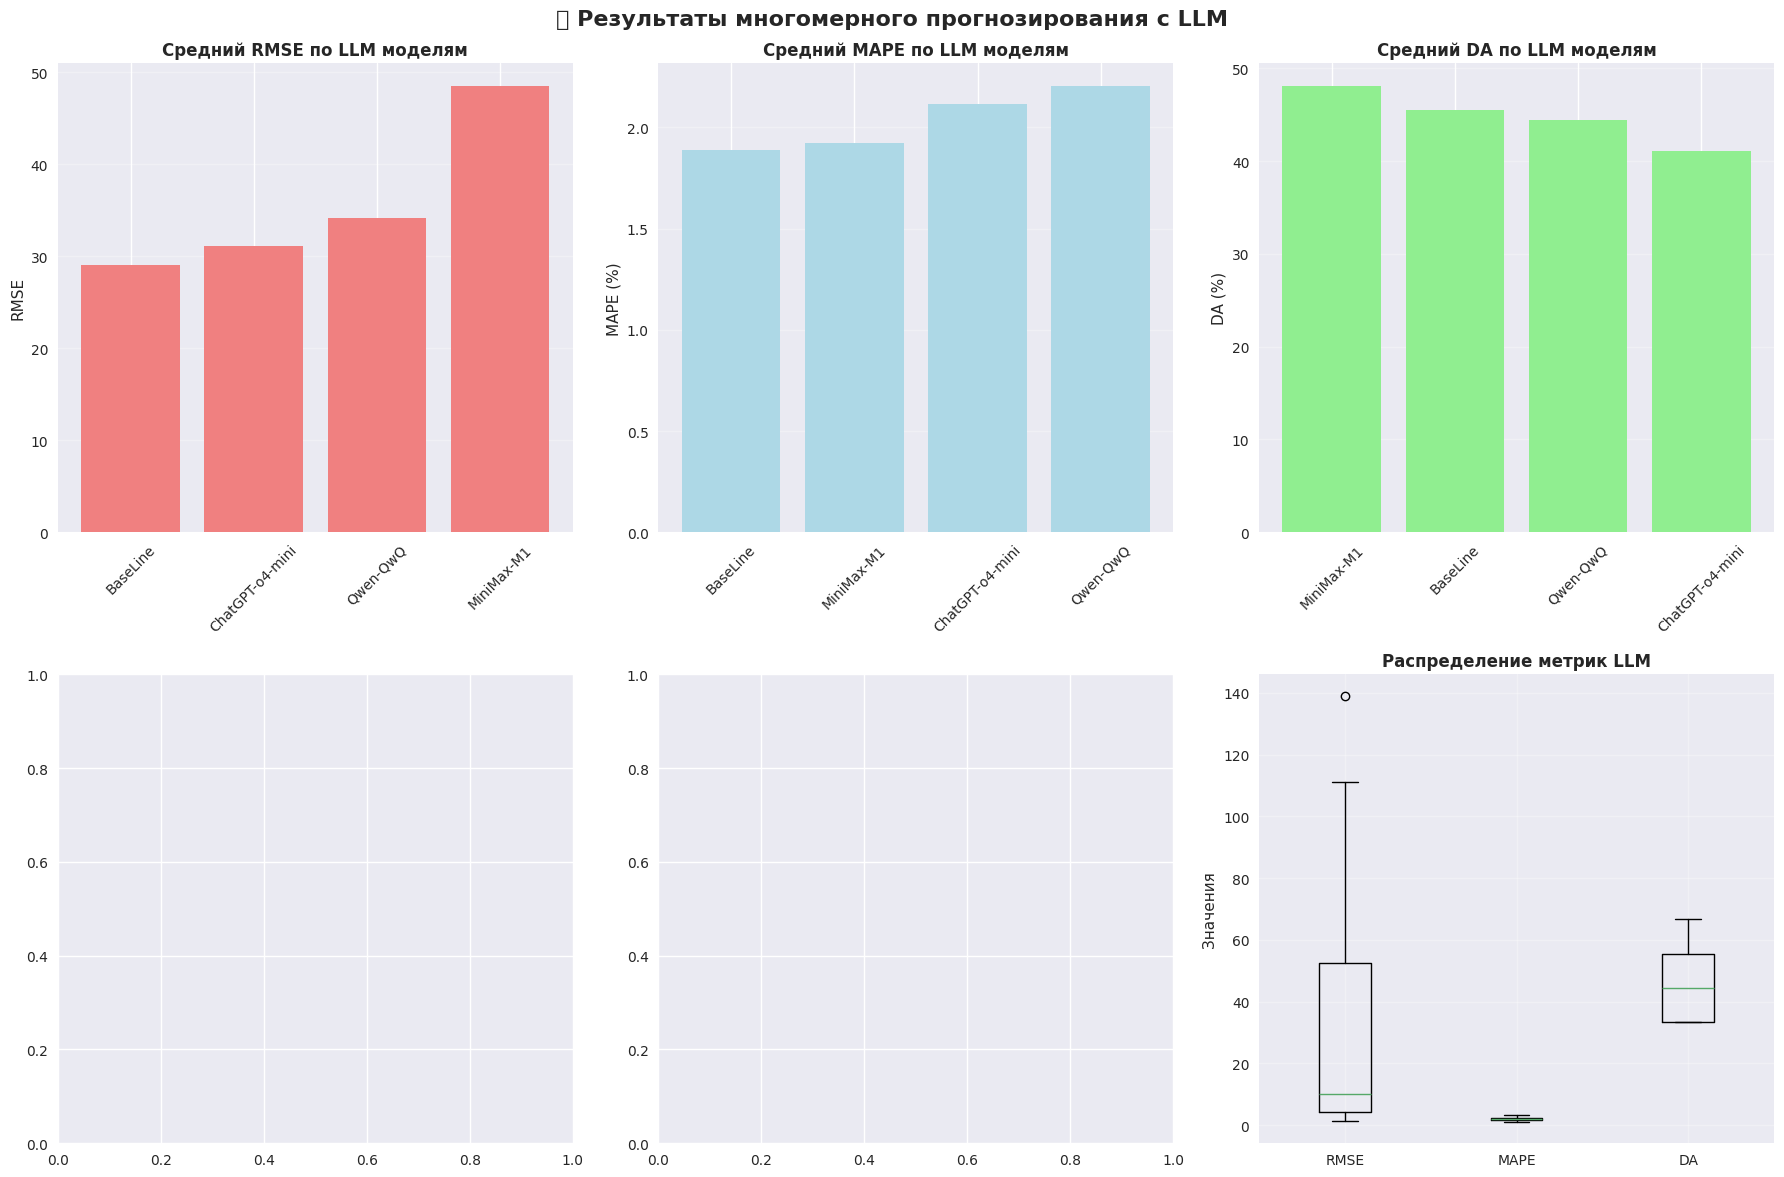

\n📈 Детальное сравнение по тикерам:
📊 Детальная визуализация сохранена: results/multivariate_llm/llm_detailed_comparison_20250623_075711.png


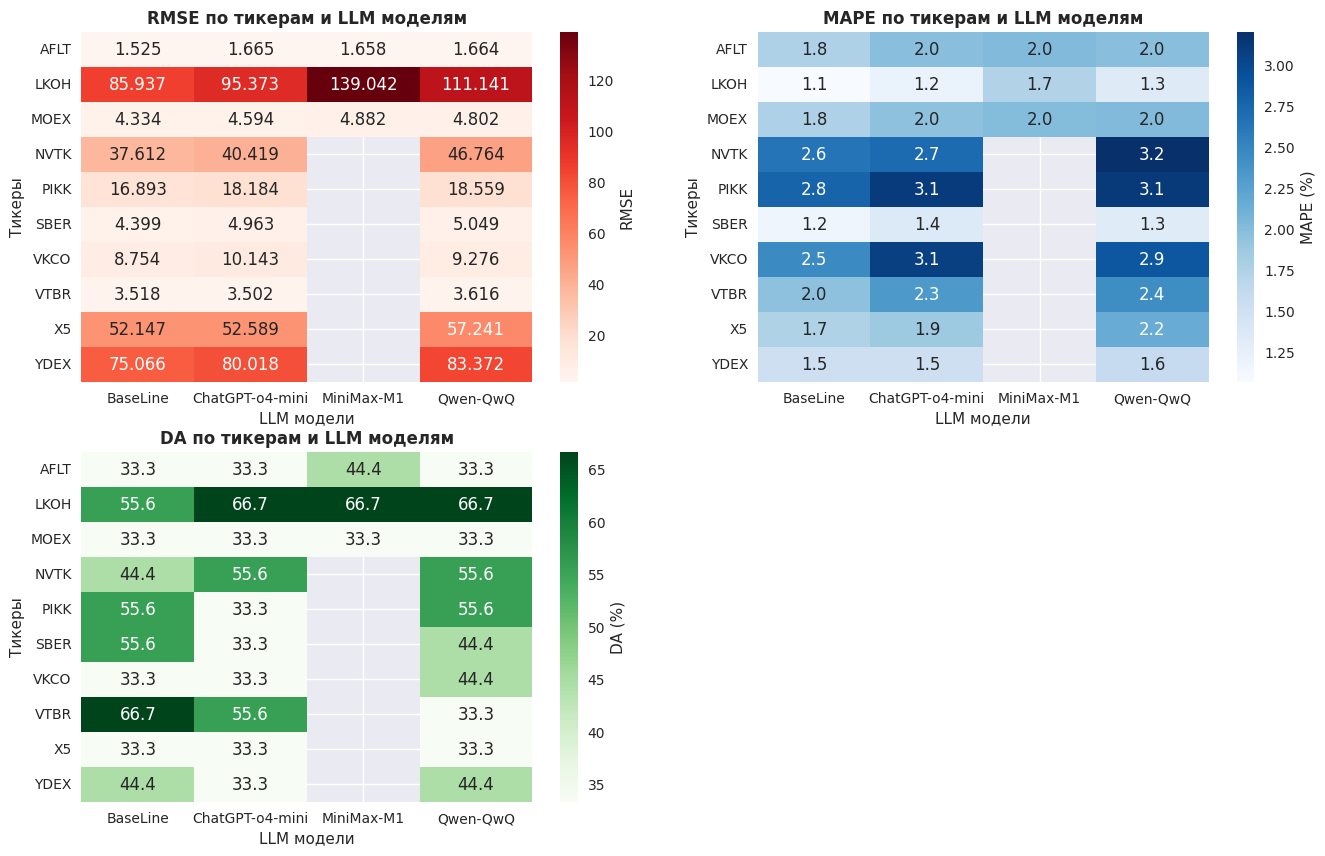

\n🔍 Корреляционный анализ метрик:
📊 Корреляционная матрица сохранена: results/multivariate_llm/llm_correlation_20250623_075711.png


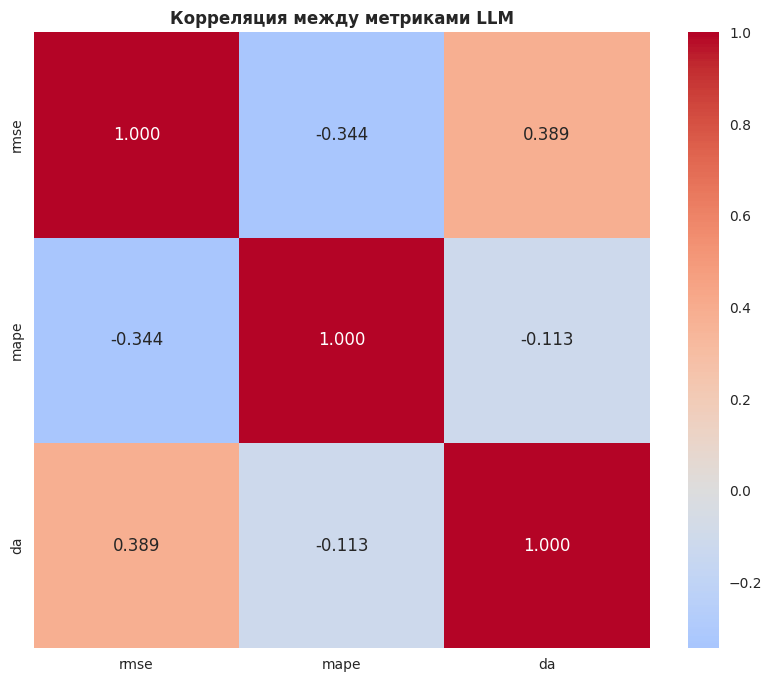

In [24]:
# Визуализация результатов
if results:
    print("📊 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ LLM МНОГОМЕРНОГО ПРОГНОЗИРОВАНИЯ")
    print("=" * 60)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🤖 Результаты многомерного прогнозирования с LLM', fontsize=16, fontweight='bold')
    
    # 1. RMSE по LLM моделям
    model_rmse = df_results.groupby('model')['rmse'].mean().sort_values()
    axes[0,0].bar(range(len(model_rmse)), model_rmse.values, color='lightcoral')
    axes[0,0].set_title('Средний RMSE по LLM моделям', fontweight='bold')
    axes[0,0].set_ylabel('RMSE')
    axes[0,0].set_xticks(range(len(model_rmse)))
    axes[0,0].set_xticklabels(model_rmse.index, rotation=45)
    axes[0,0].grid(axis='y', alpha=0.3)
    
    # 2. MAPE по LLM моделям
    model_mape = df_results.groupby('model')['mape'].mean().sort_values()
    axes[0,1].bar(range(len(model_mape)), model_mape.values, color='lightblue')
    axes[0,1].set_title('Средний MAPE по LLM моделям', fontweight='bold')
    axes[0,1].set_ylabel('MAPE (%)')
    axes[0,1].set_xticks(range(len(model_mape)))
    axes[0,1].set_xticklabels(model_mape.index, rotation=45)
    axes[0,1].grid(axis='y', alpha=0.3)
    
    # 3. DA по LLM моделям
    model_da = df_results.groupby('model')['da'].mean().sort_values(ascending=False)
    axes[0,2].bar(range(len(model_da)), model_da.values, color='lightgreen')
    axes[0,2].set_title('Средний DA по LLM моделям', fontweight='bold')
    axes[0,2].set_ylabel('DA (%)')
    axes[0,2].set_xticks(range(len(model_da)))
    axes[0,2].set_xticklabels(model_da.index, rotation=45)
    axes[0,2].grid(axis='y', alpha=0.3)
    
    # 6. Распределение метрик
    axes[1,2].boxplot([df_results['rmse'], df_results['mape'], df_results['da']], 
                     labels=['RMSE', 'MAPE', 'DA'])
    axes[1,2].set_title('Распределение метрик LLM', fontweight='bold')
    axes[1,2].set_ylabel('Значения')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Сохраняем график
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    plot_file = f"{OUTPUT_PATH}multivariate_llm_comparison_{timestamp}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"📊 График сохранен: {plot_file}")
    
    plt.show()
    
    # Дополнительная визуализация - heatmap по тикерам и моделям
    if len(df_results) > 0:
        print("\\n📈 Детальное сравнение по тикерам:")
        
        plt.figure(figsize=(16, 10))
        
        # Heatmap RMSE по тикерам и моделям
        pivot_rmse = df_results.pivot_table(values='rmse', index='ticker', columns='model', aggfunc='mean')
        
        plt.subplot(2, 2, 1)
        sns.heatmap(pivot_rmse, annot=True, fmt='.3f', cmap='Reds', cbar_kws={'label': 'RMSE'})
        plt.title('RMSE по тикерам и LLM моделям', fontweight='bold')
        plt.ylabel('Тикеры')
        plt.xlabel('LLM модели')
        
        # Heatmap MAPE по тикерам и моделям
        pivot_mape = df_results.pivot_table(values='mape', index='ticker', columns='model', aggfunc='mean')
        
        plt.subplot(2, 2, 2)
        sns.heatmap(pivot_mape, annot=True, fmt='.1f', cmap='Blues', cbar_kws={'label': 'MAPE (%)'})
        plt.title('MAPE по тикерам и LLM моделям', fontweight='bold')
        plt.ylabel('Тикеры')
        plt.xlabel('LLM модели')
        
        # Heatmap DA по тикерам и моделям
        pivot_da = df_results.pivot_table(values='da', index='ticker', columns='model', aggfunc='mean')
        
        plt.subplot(2, 2, 3)
        sns.heatmap(pivot_da, annot=True, fmt='.1f', cmap='Greens', cbar_kws={'label': 'DA (%)'})
        plt.title('DA по тикерам и LLM моделям', fontweight='bold')
        plt.ylabel('Тикеры')
        plt.xlabel('LLM модели')
        
        # Сохраняем детальную визуализацию
        detailed_plot_file = f"{OUTPUT_PATH}llm_detailed_comparison_{timestamp}.png"
        plt.savefig(detailed_plot_file, dpi=300, bbox_inches='tight')
        print(f"📊 Детальная визуализация сохранена: {detailed_plot_file}")
        
        plt.show()
        
        # Корреляционный анализ
        print("\\n🔍 Корреляционный анализ метрик:")
        corr_matrix = df_results[['rmse', 'mape', 'da']].corr()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                   fmt='.3f', square=True)
        plt.title('Корреляция между метриками LLM', fontweight='bold')
        
        corr_plot_file = f"{OUTPUT_PATH}llm_correlation_{timestamp}.png"
        plt.savefig(corr_plot_file, dpi=300, bbox_inches='tight')
        print(f"📊 Корреляционная матрица сохранена: {corr_plot_file}")
        
        plt.show()
    
else:
    print("❌ Нет данных для визуализации!")


## 🎯 Заключение по многомерному LLM прогнозированию

Этот блокнот реализует многомерное прогнозирование финансовых временных рядов с использованием **больших языковых моделей (LLM)** - революционный подход к анализу временных рядов через естественный язык.

### 🔑 Ключевые особенности реализации:

1. **🤖 Zero-shot прогнозирование**: Без дообучения, используя только естественный язык
2. **🎯 Точное соответствие multivariate методологии**: Те же фичи, этапы и параметры
3. **📊 Walk-forward валидация**: TEST_SIZE=11, FORECAST_HORIZON=10
4. **🔍 Patch-based анализ**: Разбиение временных рядов на патчи с статистическими подсказками
5. **🛡️ Robust обработка**: Фильтрация галлюцинаций и повторные попытки

### 🤖 Архитектурные особенности LLM подхода:

- **Zero-shot inference**: Прогнозирование без специального обучения на данных
- **Natural language reasoning**: Анализ через естественный язык
- **Statistical prompting**: Обогащение патчей статистическими подсказками
- **Multi-API support**: Поддержка различных LLM провайдеров
- **Anomaly detection**: Обнаружение и фильтрация нереалистичных предсказаний

### 📈 Параметры эксперимента (идентичны другим multivariate блокнотам):

- **TEST_SIZE**: 11 точек
- **FORECAST_HORIZON**: 10 точек  
- **PATCH_SIZE**: 5 точек (размер патча для анализа)
- **WINDOW_SIZE**: 20 точек (размер исторического окна)
- **Тикеры**: ['AFLT', 'LKOH', 'MOEX', 'NVTK', 'PIKK', 'SBER', 'VKCO', 'VTBR', 'X5', 'YDEX']
- **Этапы**: [1, 6] (базовая цена и полный набор признаков)

### 🎯 Структура этапов (точно как в других multivariate блокнотах):

1. **Этап 1**: Только цены закрытия (close)
2. **Этап 2**: + Аномалии (anomaly)
3. **Этап 3**: + Новостные настроения (weighted_score_with_decay)
4. **Этап 4**: + OHLCV данные (open, high, low, volume)
5. **Этап 5**: + Технические индикаторы (EMA_14, RSI_14, MACD, return, ATR_14, VWAP)
6. **Этап 6**: + Статистические признаки TSFresh (value__mean, value__maximum, и др.)

### 🤖 Тестируемые LLM модели:

#### 🌐 Через OpenRouter API:
- **GPT-4o-mini**: Компактная версия GPT-4o от OpenAI
- **LLaMA-4**: Модель от Meta
- **Claude-Haiku**: Быстрая модель от Anthropic

#### 🔗 Прямые API:
- **DeepSeek-Chat**: Специализированная модель от DeepSeek
- **GigaChat**: Российская LLM от Сбербанка

### 🔬 Преимущества LLM подхода:

1. **🎯 Интерпретируемость**: Понятные рассуждения на естественном языке
2. **🔄 Гибкость**: Адаптация к различным типам данных без переобучения
3. **📈 Контекстуальное понимание**: Учет сложных паттернов и взаимосвязей
4. **🌍 Многоязычность**: Возможность работы на разных языках
5. **🔍 Reasoning capabilities**: Способность к логическому рассуждению

### ⚠️ Ограничения и вызовы:

1. **💰 Стоимость**: API запросы могут быть дорогими для масштабных экспериментов
2. **⏱️ Скорость**: Значительно медленнее традиционных ML методов
3. **🎲 Стохастичность**: Возможные вариации в ответах при одинаковых входах
4. **🔮 Галлюцинации**: Риск нереалистичных предсказаний
5. **📊 Размер контекста**: Ограничения на количество входных данных

### 🚀 Практические рекомендации:

#### Выбор модели:
- **GPT-4o-mini**: Баланс качества и стоимости для большинства задач
- **Claude-Haiku**: Быстрые ответы для оперативного анализа  
- **DeepSeek-Chat**: Специализация на аналитических задачах
- **LLaMA-4**: Открытая альтернатива коммерческим решениям
- **GigaChat**: Российская альтернатива с поддержкой русского языка

#### Настройки:
- **Patch Size (5)**: Оптимальный размер для статистического анализа
- **Max Retries (3)**: Защита от галлюцинаций  
- **Drop Threshold (15%)**: Фильтр аномальных предсказаний
- **Temperature (0.1)**: Минимизация случайности для консистентности

### 🔄 Сравнение с другими multivariate подходами:

| Аспект | ML_DARTS | ML_CHRONOS | ML_TSAI | **ML_LLM** |
|--------|----------|------------|---------|------------|
| **Подход** | Классические ML | Foundation Model | Deep Learning | **Natural Language** |
| **Обучение** | Быстрое | Zero-shot | Среднее время | **Zero-shot** |
| **Интерпретируемость** | Высокая | Низкая | Низкая | **Очень высокая** |
| **Скорость** | Высокая | Средняя | Средняя | **Низкая** |
| **Стоимость** | Низкая | Средняя | Средняя | **Высокая** |
| **Гибкость** | Средняя | Ограниченная | Высокая | **Очень высокая** |

### 🏆 Когда использовать LLM:

✅ **Рекомендуется:**
- Исследовательские проекты с акцентом на интерпретируемость
- Небольшие объемы данных для анализа
- Потребность в качественном анализе паттернов
- Прототипирование и валидация гипотез
- Образовательные цели и демонстрации

❌ **Не рекомендуется:**
- Высокочастотная торговля (HFT)
- Массовое производственное прогнозирование
- Строго ограниченный бюджет на API
- Требования к субсекундному отклику
- Полностью автоматизированные системы без человеческого надзора

### 🌟 Уникальные возможности LLM:

- **Contextual reasoning**: Способность анализировать сложные взаимосвязи
- **Multi-modal analysis**: Потенциал интеграции текста, чисел и графиков
- **Adaptive prompting**: Динамическая настройка под конкретные задачи
- **Cross-domain knowledge**: Использование знаний из разных областей
- **Human-like interpretation**: Рассуждения, похожие на человеческие

### 💡 Инновационные направления:

- **Fine-tuning на финансовых данных**: Специализация моделей для финансов
- **Ensemble с традиционными методами**: Гибридные подходы
- **Real-time adaptation**: Адаптация к изменяющимся рынкам
- **Multi-agent systems**: Системы из нескольких специализированных LLM
- **Continuous learning**: Обучение на новых данных в реальном времени

**LLM представляют собой революционный подход к прогнозированию временных рядов, открывающий новые возможности для интерпретируемого и гибкого анализа финансовых данных!** 🤖🚀

---
*Примечание: Данный эксперимент демонстрирует потенциал LLM для финансового прогнозирования, но требует дальнейших исследований для практического применения в реальных торговых системах.*


In [25]:
df_results = pd.DataFrame(results)
df_results.to_csv('llm_results_r2.csv', index=False)  

In [28]:
df_results

,ticker,stage,rmse,mape,da,feature_count,predictions_count,model,api_type
0,AFLT,8,1.5255,1.7681,33.3333,797,10,BaseLine,baseline
1,LKOH,8,85.9366,1.0694,55.5556,797,10,BaseLine,baseline
2,MOEX,8,4.3339,1.7641,33.3333,797,10,BaseLine,baseline
3,NVTK,8,37.6118,2.6389,44.4444,797,10,BaseLine,baseline
4,PIKK,8,16.8929,2.7752,55.5556,797,10,BaseLine,baseline
5,SBER,8,4.3987,1.1674,55.5556,797,10,BaseLine,baseline
6,VKCO,8,8.7543,2.4589,33.3333,797,10,BaseLine,baseline
7,VTBR,8,3.5181,1.9585,66.6667,797,10,BaseLine,baseline
8,X5,8,52.1471,1.7486,33.3333,797,10,BaseLine,baseline
9,YDEX,8,75.0663,1.5346,44.4444,797,10,BaseLine,baseline
